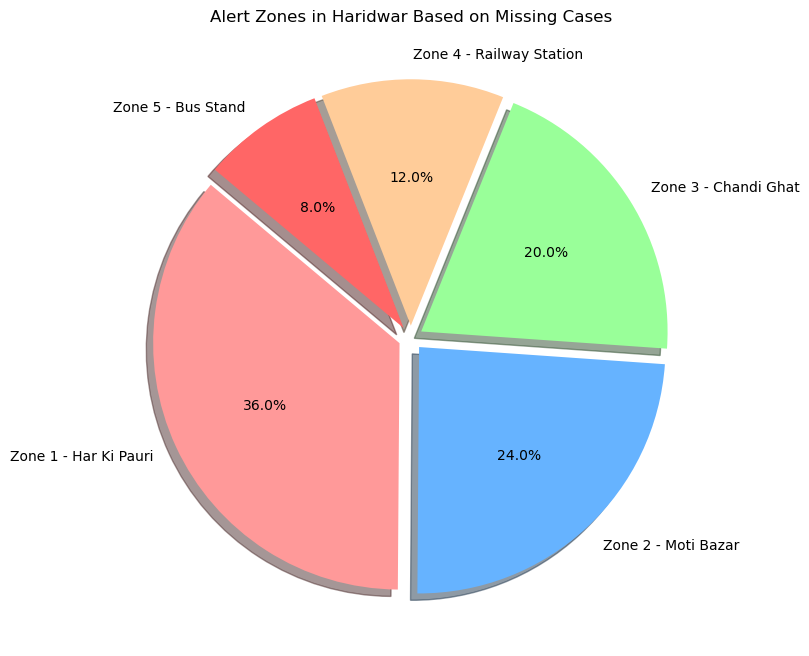

In [1]:
import matplotlib.pyplot as plt

def create_alert_zone_pie_chart(zones, cases):
    if len(zones) != len(cases):
        print("Error: The number of zones must match the number of cases.")
        return
    
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff6666'] 
    explode = [0.05] * len(zones)  

    plt.figure(figsize=(8, 8))  

    plt.pie(cases, explode=explode, labels=zones, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)

   
    plt.title('Alert Zones in Haridwar Based on Missing Cases')

   
    plt.show()

zones = ['Zone 1 - Har Ki Pauri', 'Zone 2 - Moti Bazar', 'Zone 3 - Chandi Ghat', 'Zone 4 - Railway Station', 'Zone 5 - Bus Stand']
cases = [45, 30, 25, 15, 10] 

create_alert_zone_pie_chart(zones, cases)


In [ ]:
import cv2
import numpy as np
import face_recognition
import os
from datetime import datetime
import pyttsx3
import tkinter as tk
import threading
import matplotlib.pyplot as plt

engine = pyttsx3.init()
stop_program = False
start_program = False

def start_webcam():
    global start_program
    start_program = True

def stop_webcam():
    global stop_program, start_program
    stop_program = True
    start_program = False

def create_gui():
    root = tk.Tk()
    root.title("Control Panel")
    root.configure(bg="#1e1e2f")

    button_style = {
        'font': ('Arial', 14, 'bold'),
        'bg': '#3498db',
        'fg': '#ffffff',
        'activebackground': '#2980b9',
        'activeforeground': '#ffffff',
        'width': 15,
        'height': 2,
        'relief': 'raised',
        'borderwidth': 3,
        'cursor': 'hand2'
    }

    start_button = tk.Button(root, text="Start Program", command=start_webcam, **button_style)
    start_button.pack(pady=20)

    stop_button = tk.Button(root, text="Stop Program", command=stop_webcam, **button_style)
    stop_button.pack(pady=20)

    root.geometry("400x250")
    root.mainloop()

path = 'C:/xampp/htdocs/thecodexcrew/wb/uploads'
images = []
classNames = []
myList = os.listdir(path)

for cl in myList:
    curImg = cv2.imread(f'{path}/{cl}')
    if curImg is None:
        print(f"Image not found or unable to read: {cl}")
        continue
    images.append(curImg)
    classNames.append(os.path.splitext(cl)[0])

def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encodes = face_recognition.face_encodings(img)
        if len(encodes) > 0:
            encodeList.append(encodes[0])
        else:
            print("No face found in one of the images!")
    return encodeList

def markAttendance(name):
    file_path = 'C:/xampp/htdocs/thecodexcrew/wb/data.csv'
    if not os.path.exists(file_path):
        with open(file_path, 'w') as f:
            f.write('Name,Time\n')
    with open(file_path, 'r+') as f:
        myDataList = f.readlines()
        nameList = []
        for line in myDataList:
            entry = line.split(',')
            nameList.append(entry[0])
        if name not in nameList:
            now = datetime.now()
            dtString = now.strftime('%H:%M:%S')
            f.writelines(f'\n{name},{dtString}')

encodeListKnown = findEncodings(images)
print('Encoding Complete')
total_frames = 0
correct_detections = 0
accuracy_list = []

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 250)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 250)

gui_thread = threading.Thread(target=create_gui)
gui_thread.start()

while True:
    if start_program:
        success, img = cap.read()
        imgS = cv2.resize(img, (0, 0), None, 0.6, 0.6)
        imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

        facesCurFrame = face_recognition.face_locations(imgS)
        encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)

        for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
            matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
            faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)
            matchIndex = np.argmin(faceDis)

            if matches[matchIndex]:
                name = classNames[matchIndex].upper()
                correct_detections += 1  

                y1, x2, y2, x1 = faceLoc
                y1, x2, y2, x1 = y1 * 2, x2 * 2, y2 * 2, x1 * 2
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.rectangle(img, (x1, y2 - 35), (x2, y2), (0, 255, 0), cv2.FILLED)
                cv2.putText(img, name, (x1 + 6, y2 - 6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)

                print(f"Suspect is found: {name}")
                cv2.putText(img, "SUSPECT IS FOUND", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                engine.say("Suspect is found")
                engine.runAndWait()

                markAttendance(name)

            total_frames += 1 
        if total_frames > 0:
            accuracy = (correct_detections / total_frames) * 100
            accuracy_list.append(accuracy)

        cv2.imshow('Webcam', img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    if stop_program:
        print("Program is stopping...")
        break

cap.release()
cv2.destroyAllWindows()
plt.plot(accuracy_list, label='Accuracy (%)')
plt.xlabel('Frames')
plt.ylabel('Accuracy')
plt.title('Face Recognition Accuracy Over Time')
plt.legend()
plt.show()


Encoding Complete
